<a href="https://colab.research.google.com/github/MatveiKondratiev/Gender-Bias-Footprint/blob/main/TEST_PRJ_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Logistic regression with "Human test"__

---



In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression #cuz values nominative)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, fbeta_score, accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import statsmodels.api as sm
from statsmodels.multivariate.factor import Factor
from sklearn.decomposition import FactorAnalysis

import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot
#!pip install factor_analyzer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

#### Data

The data relate to the answers to the questionnaire questions, which is designed to identify respondents as free from gender prejudice as possible - a "human" (H). The classification goal is to predict if questionnaire is H or female(F) or male(M) or a type that mixes gender sterotypes "male-human"(MH), "female-human"(FH).

- We must maximize Recall (TRP), because human recognition is the highest priority and also not forget about Precission (PPV), but if a FH is identified as a H, it is not a big loss. The F-score metric with a weight equal to the ratio of 4:1, that is, 0.8, is best suited for this.

- Also, since the sample is small and the variance associated with VAR is high, it is necessary to use a method of reducing it (random forest, CV).

It was decided that a two-stage classification was more appropriate.

In [ ]:
# Import data set
sheet_id = '1wp7QU2X2lYCDxHkgong1nLOyBKhnF40Whyp747wYrFo'

train = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")
train = train.drop(['Баллы','Отметка времени','4.1 Мужчина должен стараться выглядеть хорошо','4.2 ВСЕ должны стараться выглядеть хорошо'], axis = 1)
train = train.drop([0,1], axis = 0)
df = train.rename(columns={'1. Укажите Ваш пол': 'sex',
                           '2. Я стараюсь не показывать всё, что у меня на уме':'HE_2', # Hiding Emotions
                           '3. Мне не важно, какой ориентации будет мой ребенок':'CO_3', #Child Orientation
                           '4. Девушка должна стараться выглядеть хорошо':'WA_4', # Woman Appirance
                           '5. Я считаю, что есть темы, в которых я должен разбираться':'UT_5', # Understand topics
                           '6. Если мой сын в школе будет драться, я его осужу': 'SF_6', # Son's Fight
                           '7. Иногда мне хочется быть слабым(-ой)': 'WBW_7', #Wanting to Be Weak
                           '8. Мужчина должен брать ответственность': 'MR_8', # Men's Responsibility
                           '9. Я считаю, что есть темы в которых я НЕ должен разбираться ': 'NUT_9', #do Not Understand the Topics
                           '10. Если моя дочь в школе будет драться, я её осужу': 'DF_10', # Daughter's fight
                           '11. Я стараюсь не показывать слабость': 'HW_11', # Hide Weaknesses
                           'Ваше ФИО':'name'
                           }
                  )
# Creating upgrade table
df_mark = df[['Mark', 'sex']]
df_mark['Mark_1'] = df_mark.Mark # Creation second col for "first" class, cuz h\other is zero class.
df_resp = df.iloc[:,1:11]
df_map = df_resp.copy()

mark_dict = {'h':1,
             'fh':0,
             'mh':0,
             'f':0,
             'm':0,
             'Мужской':1,
             'Женский':0}
mark_1_dict = {'h':1,
             'fh':1,
             'mh':1,
             'f':0,
             'm':0,
             'Мужской':1,
             'Женский':0}



# ключами будут старые значения признака
# значениями словаря - новые значения признака
map_dict_first = {'Полностью согласен': 1,
            'Скорее согласен':0.5,
            'Затрудняюсь ответить' : 0,
            'Скорее не согласен' : -0.5,
            'Полностью несогласен': -1}

map_dict = {'Полностью согласен': 1,
            'Скорее согласен':0.75,
            'Затрудняюсь ответить' : 0.5,
            'Скорее не согласен' : 0.25,
            'Полностью несогласен': 0}

#for i in range(len(df_map.columns)):
spec_columns = ['MR_8','NUT_9']
for i in spec_columns:
  df_map[i] = df_map[i].map(map_dict_first)



for i in spec_columns:
  df_map[i] = df_map[i]/2+0.5

spec_columns.append('CEQ')
columns = df_map.columns
other_columns = [x for x in columns if x not in spec_columns]

for i in other_columns:
  df_map[i] = df_map[i].map(map_dict)

# Total dataframe
t_df = df_mark.join(df_map)

t_df['TS'] = (t_df.NUT_9 * t_df.MR_8) # Thick skin
t_df['CEQ'] = (t_df.SF_6 * t_df.DF_10) # Child equality
t_df.Mark = t_df.Mark.map(mark_dict)
t_df.Mark_1 = t_df.Mark_1.map(mark_1_dict)
t_df.sex = t_df.sex.map(mark_dict)

t_df.head()

<ipython-input-2-aa2b723c0699>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mark['Mark_1'] = df_mark.Mark # Creation second col for "first" class, cuz h\other is zero class.


,Mark,sex,Mark_1,HE_2,CO_3,WA_4,UT_5,SF_6,WBW_7,MR_8,NUT_9,DF_10,HW_11,TS,CEQ
2,1.0,0,1.0,0.75,1.00,0.75,0.00,0.25,0.25,0.25,0.00,0.25,1.00,0.000,0.0625
3,0.0,0,1.0,0.25,0.00,0.75,0.75,0.25,1.00,0.00,1.00,0.25,0.75,0.000,0.0625
4,0.0,1,0.0,0.00,0.25,0.25,1.00,0.75,0.25,0.75,0.00,0.75,0.00,0.000,0.5625
5,1.0,0,1.0,0.75,1.00,0.25,1.00,1.00,0.25,0.50,0.25,1.00,0.75,0.125,1.0000
6,0.0,0,0.0,0.25,0.50,0.00,1.00,0.25,1.00,1.00,1.00,0.25,0.75,1.000,0.0625


In [ ]:
t_df.describe().T  # Сhecking that all elements are converted correctly

,count,mean,std,min,25%,50%,75%,max
Mark,53.0,0.415094,0.497454,0.0,0.0000,0.00,1.0000,1.0
sex,65.0,0.461538,0.502398,0.0,0.0000,0.00,1.0000,1.0
Mark_1,53.0,0.547170,0.502533,0.0,0.0000,1.00,1.0000,1.0
HE_2,65.0,0.619231,0.315943,0.0,0.2500,0.75,0.7500,1.0
CO_3,65.0,0.507692,0.421514,0.0,0.0000,0.50,1.0000,1.0
WA_4,65.0,0.569231,0.360413,0.0,0.2500,0.75,0.7500,1.0
UT_5,65.0,0.780769,0.332215,0.0,0.7500,1.00,1.0000,1.0
SF_6,65.0,0.511538,0.310716,0.0,0.2500,0.50,0.7500,1.0
WBW_7,65.0,0.569231,0.354953,0.0,0.2500,0.75,1.0000,1.0
MR_8,65.0,0.734615,0.327386,0.0,0.5000,0.75,1.0000,1.0


#### EDA


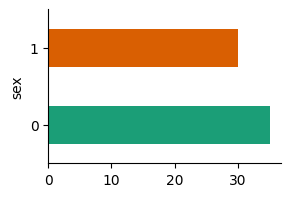

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
t_df.groupby('sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'),figsize=(3,2))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#sns.catplot(x='sex',col = 'Mark',kind = 'count', data=t_df, height = 2,aspect = 1, palette = 'Set2');

<ipython-input-6-95f4cbed0e40>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='sex',col = 'Mark_1',kind = 'count', data=t_df, height = 2,aspect = 1, palette = 'Set2');


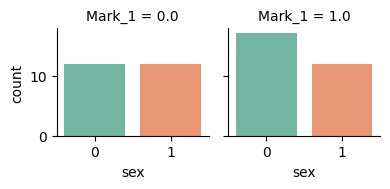

In [ ]:
sns.catplot(x='sex',col = 'Mark_1',kind = 'count', data=t_df, height = 2,aspect = 1, palette = 'Set2');

In [ ]:
t_df.dropna(subset=['Mark'], inplace=True) # cuz for now we use Supervised paradigm
t_df.shape

(53, 15)

In [ ]:
pd.crosstab([t_df.Mark, t_df.sex], t_df.CO_3, margins = True).style.background_gradient(cmap = 'autumn_r')

##### GENDER SPLIT

In [ ]:
df_male = t_df[t_df['sex'] == 1]
df_fem = t_df[t_df['sex'] == 0]

# We should drop NA value from Mark column, cuz they aren't all marked up.
df_fem = df_fem[df_fem['Mark'].notna()].drop(['sex'],axis = 1)
df_male = df_male[df_male['Mark'].notna()].drop(['sex'],axis = 1)

In [ ]:
pd.crosstab([df_male.Mark], df_male.CO_3, margins = True).style.background_gradient(cmap = 'autumn_r')

CO_3,0.000000,0.250000,0.500000,0.750000,1.000000,All
Mark,,,,,,
0.000000,8,5,0,2,0,15
1.000000,0,0,1,0,8,9
All,8,5,1,2,8,24


In [ ]:
pd.crosstab([df_fem.Mark], df_fem.CO_3, margins = True).style.background_gradient(cmap = 'autumn_r')

CO_3,0.000000,0.250000,0.500000,0.750000,1.000000,All
Mark,,,,,,
0.000000,8,4,2,0,2,16
1.000000,0,0,0,4,9,13
All,8,4,2,4,11,29


<u>__Social conclusion 1 (SC1)__</u>: <br>_It can be seen that men are more "Confident" compared to women_ (they often choose extreme answers).

In [ ]:
X = t_df.drop(['Mark','Mark_1'], axis = 1) #,'HE_2','WA_4','UT_5','CEQ'
y = t_df['Mark']

X_train,  X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 44)

y_train = y_train.astype(int)


### LOG.REGR. <br>All Features, without SEX SPLIT

0.6363636363636364


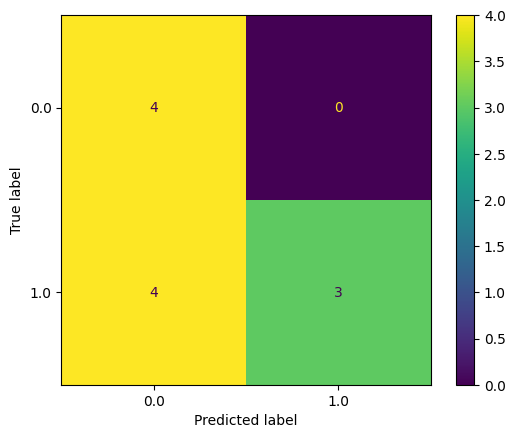

In [ ]:
mod=LogisticRegression(random_state=44)
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
print(fbeta_score(y_test, y_pred, average='micro', beta=4))
cm=ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

#### Finding best features.
before spliting by sex.

##### Via automatic RFE

In [ ]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LogisticRegression())

In [ ]:
model = LogisticRegression()

In [ ]:
pipeline_a = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, )
n_scores = cross_val_score(pipeline_a, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.8690909090909091

In [ ]:
pipeline_a.fit(X_train,y_train)

Pipeline(steps=[('Feature Selection', RFECV(estimator=LogisticRegression())),
                ('Model', LogisticRegression())])

In [ ]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 2


In [ ]:
#rfecv.support_
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df.head()

,Rank
CO_3,1
TS,1
NUT_9,2
WA_4,3
HW_11,4


In [ ]:
rfecv.cv_results_['mean_test_score']

array([0.85555556, 0.90277778, 0.87777778, 0.87777778, 0.87777778,
       0.85277778, 0.85277778, 0.85277778, 0.85277778, 0.85277778,
       0.85277778, 0.85277778, 0.85277778])

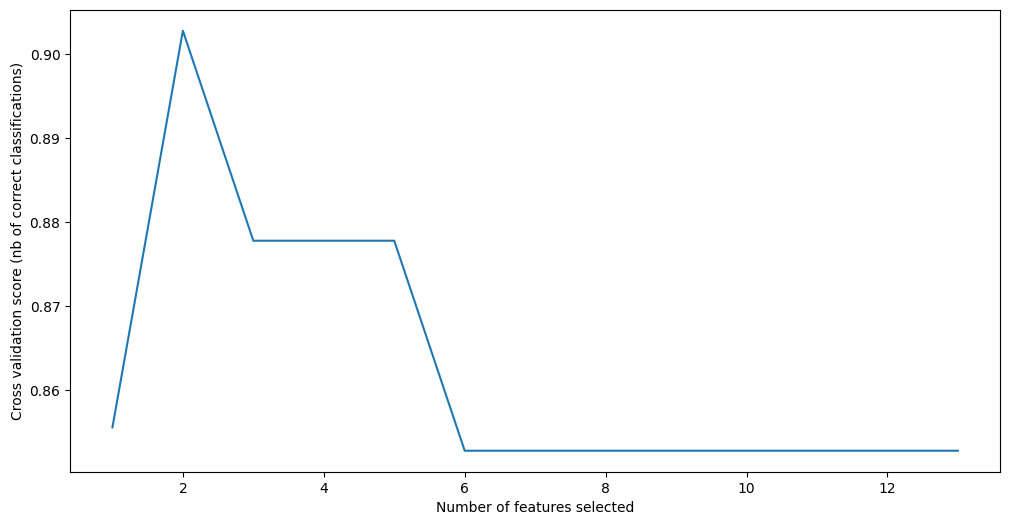

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [ ]:
rfe_total = RFE(estimator=LogisticRegression(), n_features_to_select=2)

In [ ]:
pipe = Pipeline([('Feature Selection', rfe_total), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=44)
n_scores = cross_val_score(pipe, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.8916666666666666

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=LogisticRegression(), n_features_to_select=2)),
                ('Model', LogisticRegression())])

##### Test f score General

In [ ]:
pipe_test = Pipeline([('Feature Selection', rfe_total), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=44)
n_scores = cross_val_score(pipe_test, X_test, y_test, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.825

###### Best Fueatures General
First tier: <br>
- CO_3
- TS <br>

Second tier: <br>
- NUT_9
- WA_4


##### Via Correlation matrix

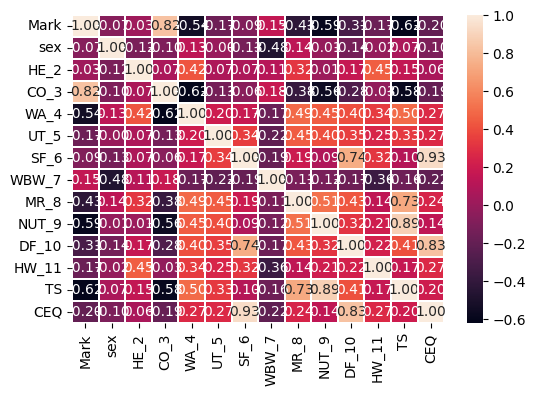

In [ ]:
# Correlation matrix COMMON
corr = (t_df.drop(['Mark_1'],axis=1).corr())

f,ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr, annot = True, linewidths=1.2 , fmt = '.2f',ax=ax)
plt.show()

In [ ]:
#X_train.columns

In [ ]:
# we drop highly corr features (>0.7) and non-informative such as HE_2 and Sex
logit_model=sm.Logit(y_train,X_train.drop(['HE_2','sex','UT_5','MR_8','SF_6','WBW_7','CEQ','DF_10','WA_4'], axis = 1))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.190937
         Iterations 9
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Mark             Pseudo R-squared: 0.707     
Date:               2024-08-23 06:31 AIC:              24.0387   
No. Observations:   42               BIC:              30.9894   
Df Model:           3                Log-Likelihood:   -8.0194   
Df Residuals:       38               LL-Null:          -27.374   
Converged:          1.0000           LLR p-value:      2.0005e-08
No. Iterations:     9.0000           Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
CO_3       6.0082     2.5034    2.4000   0.0164    1.1017   10.9148
NUT_9     -2.1730     3.3275   -0.6530   0.5137   -8.6948 

In [ ]:
logit_model=sm.Logit(y_train,X_train[['CO_3','WBW_7','DF_10','TS']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.184146
         Iterations 10
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Mark             Pseudo R-squared: 0.717     
Date:               2024-08-23 06:32 AIC:              23.4683   
No. Observations:   42               BIC:              30.4190   
Df Model:           3                Log-Likelihood:   -7.7341   
Df Residuals:       38               LL-Null:          -27.374   
Converged:          1.0000           LLR p-value:      1.5146e-08
No. Iterations:     10.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
CO_3      8.2493     3.8591    2.1376   0.0325     0.6856   15.8131
WBW_7    -3.3365     3.0247   -1.1031   0.2700    -9.2648

##### Optimize feat


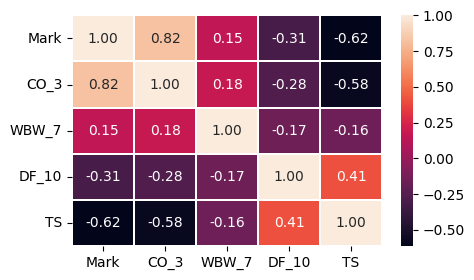

In [ ]:
# Optimize Correlation matrix COMMON
t_df_c =t_df.drop(['Mark_1','HE_2','sex','UT_5','MR_8','SF_6','WA_4','NUT_9','HW_11','CEQ'],axis=1)
corr = t_df_c.corr()

f,ax = plt.subplots(figsize=(5,3))
sns.heatmap(corr, annot = True, linewidths=1.2 , fmt = '.2f',ax=ax)
plt.show()

Train :0.9047619047619048
Test :0.6363636363636364


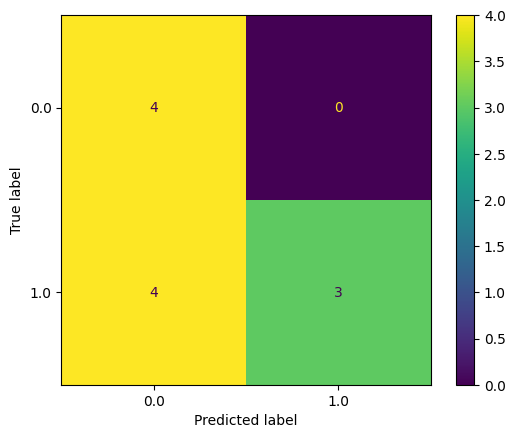

In [ ]:


mod1=LogisticRegression(random_state=44)
mod1.fit(X_train, y_train)
y_pred = mod1.predict(X_train)
print(f"Train :{fbeta_score(y_train, y_pred, average='micro', beta=4)}")
print(f"Test :{fbeta_score(y_test, mod1.predict(X_test) , average='micro', beta=4)}")
cm=ConfusionMatrixDisplay.from_predictions(y_test,mod1.predict(X_test))

##### PR-curve

In [ ]:
#standartize inputs
scaler = StandardScaler().fit(X_train) # стандартизуем на 1 дисп и 0 мат ожидание
X_train_scaled = scaler.transform(X_train) #применяем станд скалер к данным

#fit log regr
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
probs = logreg.predict_proba(X_train_scaled)
scores = probs[:,1]
scores

array([0.01023534, 0.0042306 , 0.02833129, 0.02292019, 0.46255754,
       0.04560685, 0.74420167, 0.00368381, 0.06541434, 0.38275465,
       0.01045179, 0.02654399, 0.93632351, 0.00331903, 0.08741445,
       0.7254212 , 0.17625503, 0.07043364, 0.18594077, 0.85325747,
       0.82028963, 0.94154443, 0.81199133, 0.65032007, 0.05175755,
       0.32953274, 0.00346066, 0.01265342, 0.50648011, 0.04112025,
       0.95728031, 0.97564988, 0.97097188, 0.01600075, 0.00483901,
       0.0111361 , 0.61887275, 0.7746132 , 0.05512573, 0.00535556,
       0.94062923, 0.65515635])

In [ ]:
# iterate threshold classifiers

thresholds = np.linspace(0.0, 1.0, 50)
tprs, fprs, precs = [], [], []
for th in thresholds:
  labels_train_pred = (scores > th).astype(int)
  M = confusion_matrix(y_train, labels_train_pred, labels = [1,0])
  tp, fn, fp, tn = M.ravel()
  #print(M)

  if tp+fn > 0:
    tpr = tp / (tp+fn)
  else:
    tpr = np.nan
  #print(tpr)
  if tn+fp > 0:
    fpr = fp / (tn+fp)
  else:
    fpr = np.nan
  if tp+fp > 0:
    prec = tp / (tp+fp)
  else:
    prec = np.nan
  tprs.append(tpr)
  fprs.append(fpr)
  precs.append(prec)
tprs = np.array(tprs)
fprs = np.array(fprs)
precs = np.array(precs)

0.9802469135802468


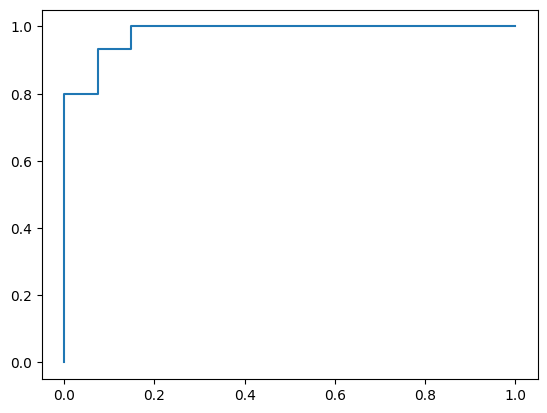

In [ ]:
# plot ROC curve

pyplot.figure()
pyplot.plot(fprs,tprs)
print(metrics.auc(fprs, tprs))

nan


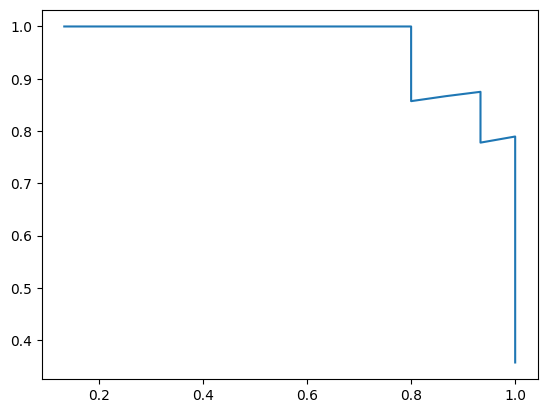

In [ ]:
# plot PR curve

pyplot.figure()
pyplot.plot(tprs,precs)
print(metrics.auc(tprs,precs))

### Split DS by gender
In order to in order to apply binary classification(logistic regression)

In [ ]:
df_male = t_df[t_df['sex'] == 1]
df_fem = t_df[t_df['sex'] == 0]

# We should drop NA value from Mark column, cuz they aren't all marked up.
df_fem = df_fem[df_fem['Mark'].notna()].drop(['sex'],axis = 1)
df_male = df_male[df_male['Mark'].notna()].drop(['sex'],axis = 1)

#df_male.dropna(subset=['Mark'], inplace=True)
#df_fem.dropna(subset=['Mark'], inplace=True)

#df_male.info()
#df_fem.info()

#### Male


In [ ]:
X_m = df_male.drop(['Mark','Mark_1'], axis = 1) #,'HE_2','WA_4','UT_5','CEQ'
y_m = df_male['Mark']

X_train_m,  X_test_m,y_train_m, y_test_m = train_test_split(X_m,y_m,test_size = 0.3, random_state = 44)

##### Via automatic RFE

In [ ]:
rfecv_m = RFECV(estimator=LogisticRegression())

In [ ]:
pipeline_m = Pipeline([('Feature Selection', rfecv_m), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10 )
n_scores = cross_val_score(pipeline_m, X_train_m, y_train_m, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.79375

In [ ]:
pipeline_m.fit(X_train_m,y_train_m)

Pipeline(steps=[('Feature Selection', RFECV(estimator=LogisticRegression())),
                ('Model', LogisticRegression())])

In [ ]:
print('Optimal number of features : %d' % rfecv_m.n_features_)

Optimal number of features : 2


In [ ]:
#rfecv.support_
rfecv_df = pd.DataFrame(rfecv_m.ranking_,index=X_train_m.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df.head()

,Rank
CO_3,1
TS,1
WBW_7,2
NUT_9,3
HE_2,4


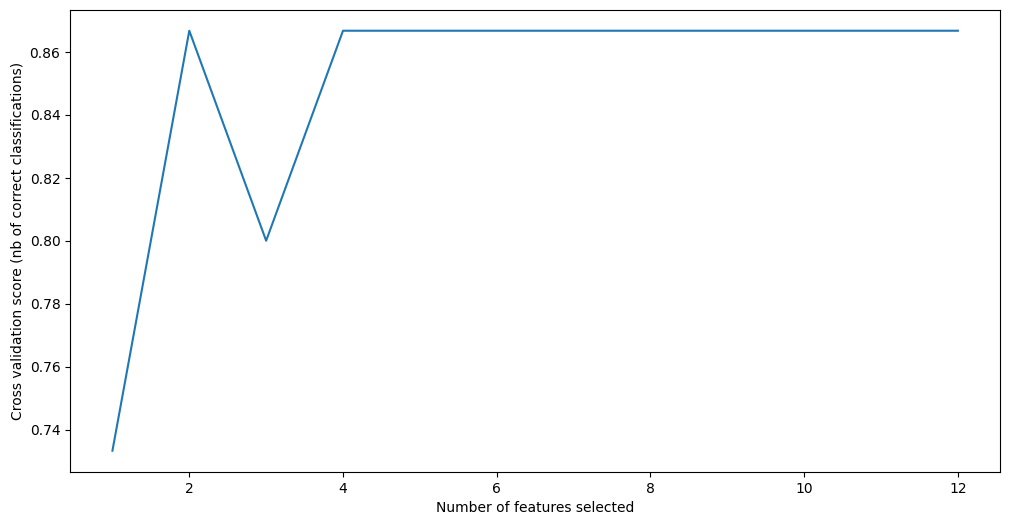

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_m.cv_results_['mean_test_score']) + 1), rfecv_m.cv_results_['mean_test_score'])
plt.show()

##### Via RFE

In [ ]:
rfe_m = RFE(estimator=LogisticRegression(), n_features_to_select=2)

In [ ]:
pipe_m = Pipeline([('Feature Selection', rfe_m), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
n_scores = cross_val_score(pipe_m, X_train_m, y_train_m, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.8483333333333334

In [ ]:
pipe_m.fit(X_train_m, y_train_m)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=LogisticRegression(), n_features_to_select=2)),
                ('Model', LogisticRegression())])

In [ ]:
rfe_m.get_feature_names_out()


array(['CO_3', 'TS'], dtype=object)

##### Test f score Male

In [ ]:
#pipe_tes = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10)
n_scores = cross_val_score(pipe_m, X_test_m, y_test_m, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.95

###### Best Fueatures Male
First tier: <br>
- CO_3
- TS <br>

Second tier: <br>
- WBW_7
- NUT_9

##### Via Correlation

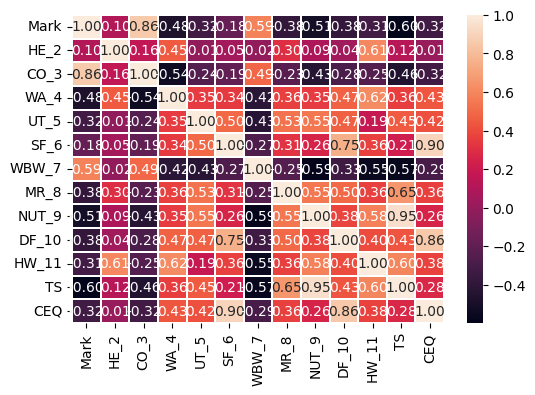

In [ ]:
# Correlation matrix MALE
corr = (df_male.drop(['Mark_1'],axis=1).corr())

f,ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr, annot = True, linewidths=1.2 , fmt = '.2f',ax=ax)
plt.show()

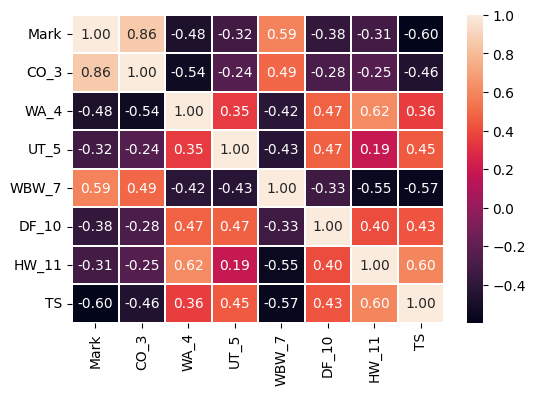

In [ ]:
# Correlation matrix MALE Optimize

#df_male_c = df_male.drop(['name','Mark_1','HE_2','SF_6','MR_8','NUT_9','HW_11','CEQ'],axis=1)

corr = df_male.drop(['Mark_1','CEQ','SF_6','MR_8','NUT_9','HE_2'], axis = 1).corr()

f,ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr, annot = True, linewidths=1.2 , fmt = '.2f',ax=ax)
plt.show()

In [ ]:
# 4 features: we drop highly corr features (>0.7) and non-informative such as HE_2 and Sex
logit_model=sm.Logit(y_train_m,X_train_m[['CO_3','TS','WBW_7','NUT_9']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.135604
         Iterations 11
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Mark             Pseudo R-squared: 0.782    
Date:               2024-08-23 06:46 AIC:              12.3393  
No. Observations:   16               BIC:              15.4297  
Df Model:           3                Log-Likelihood:   -2.1697  
Df Residuals:       12               LL-Null:          -9.9374  
Converged:          1.0000           LLR p-value:      0.0014118
No. Iterations:     11.0000          Scale:            1.0000   
-----------------------------------------------------------------
            Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
-----------------------------------------------------------------
CO_3         8.0507   16.6197   0.4844  0.6281  -24.5232  40.6246
TS         -16.3450   17.2176  -0.9493  0.3425  -50.0909  17.4010
WBW_7  

In [ ]:
# 3 Features: we drop highly corr features (>0.7) and non-informative such as HE_2 and Sex
logit_model=sm.Logit(y_train_m,X_train_m[['CO_3','TS','WBW_7']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.144418
         Iterations 11
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Mark             Pseudo R-squared: 0.767     
Date:               2024-08-23 06:47 AIC:              10.6214   
No. Observations:   16               BIC:              12.9391   
Df Model:           2                Log-Likelihood:   -2.3107   
Df Residuals:       13               LL-Null:          -9.9374   
Converged:          1.0000           LLR p-value:      0.00048727
No. Iterations:     11.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.     Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
CO_3     12.0556    19.3096    0.6243   0.5324   -25.7905   49.9017
TS      -11.5371    13.2049   -0.8737   0.3823   -37.4183

In [ ]:
# 2 features: we drop highly corr features (>0.7) and non-informative such as HE_2 and Sex
logit_model=sm.Logit(y_train_m,X_train_m[['CO_3','TS']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.150067
         Iterations 9
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Mark             Pseudo R-squared: 0.758     
Date:               2024-08-23 06:47 AIC:              8.8021    
No. Observations:   16               BIC:              10.3473   
Df Model:           1                Log-Likelihood:   -2.4011   
Df Residuals:       14               LL-Null:          -9.9374   
Converged:          1.0000           LLR p-value:      0.00010345
No. Iterations:     9.0000           Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
CO_3      5.5195     3.5874    1.5386   0.1239    -1.5117   12.5508
TS       -7.7932     4.9989   -1.5590   0.1190   -17.5909 

#### Female

In [ ]:
X_f = df_fem.drop(['Mark','Mark_1'], axis = 1) #,'HE_2','WA_4','UT_5','CEQ'
y_f = df_fem['Mark']

X_train_f,  X_test_f,y_train_f, y_test_f = train_test_split(X_f,y_f,test_size = 0.3, random_state = 44)

##### Via automatic RFE

In [ ]:
rfecv_f = RFECV(estimator=LogisticRegression())

In [ ]:
pipeline_f = Pipeline([('Feature Selection', rfecv_f), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10 )
n_scores = cross_val_score(pipeline_f, X_train_f, y_train_f, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.6850000000000002

In [ ]:
pipeline_f.fit(X_train_f,y_train_f)

Pipeline(steps=[('Feature Selection', RFECV(estimator=LogisticRegression())),
                ('Model', LogisticRegression())])

In [ ]:
print('Optimal number of features : %d' % rfecv_f.n_features_)

Optimal number of features : 4


In [ ]:
#rfecv.support_
rfecv_df = pd.DataFrame(rfecv_f.ranking_,index=X_train_f.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df

,Rank
CO_3,1
MR_8,1
NUT_9,1
TS,1
WA_4,2
HW_11,3
DF_10,4
UT_5,5
WBW_7,6
CEQ,7


In [ ]:
rfecv_f.cv_results_['mean_test_score']

array([0.75, 0.75, 0.75, 0.8 , 0.8 , 0.8 , 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75])

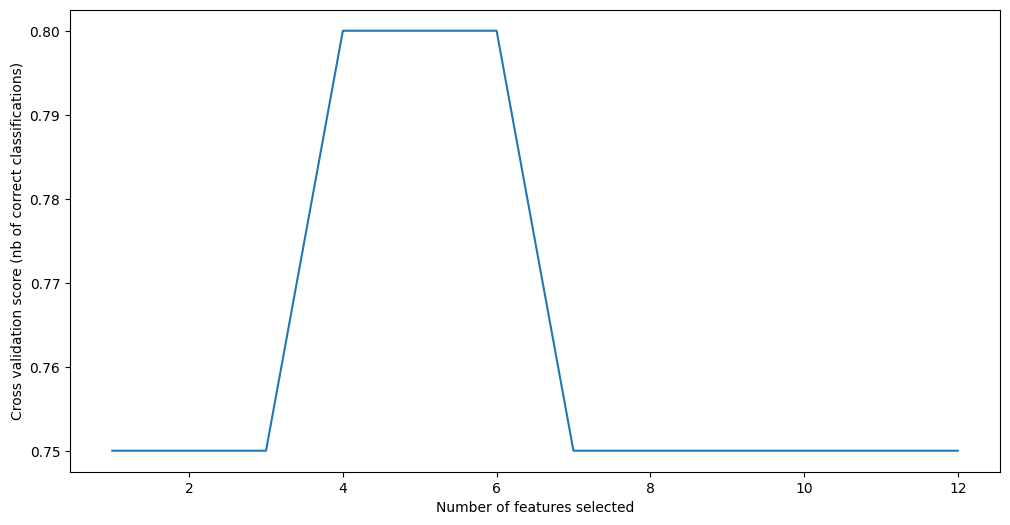

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_f.cv_results_['mean_test_score']) + 1), rfecv_f.cv_results_['mean_test_score'])
plt.show()

##### Via RFE

In [ ]:
rfe_f = RFE(estimator=LogisticRegression(), n_features_to_select=4)

In [ ]:
model = LogisticRegression()

In [ ]:
pipe_f = Pipeline([('Feature Selection', rfe_f), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
n_scores = cross_val_score(pipe_f, X_train_f, y_train_f, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.74

In [ ]:
pipe_f.fit(X_train_f, y_train_f)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=LogisticRegression(), n_features_to_select=4)),
                ('Model', LogisticRegression())])

In [ ]:
rfe_f.get_feature_names_out()


array(['CO_3', 'MR_8', 'NUT_9', 'TS'], dtype=object)

##### Test f score

In [ ]:
#pipe_tes = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10)
n_scores = cross_val_score(pipe_f, X_test_f, y_test_f, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

1.0

###### Best Fueatures Female
First tier: <br>
- CO_3
- MR_8
- NUT_9
- TS

Second tier: <br>
- WA_4
- HW_11

##### Via correlation

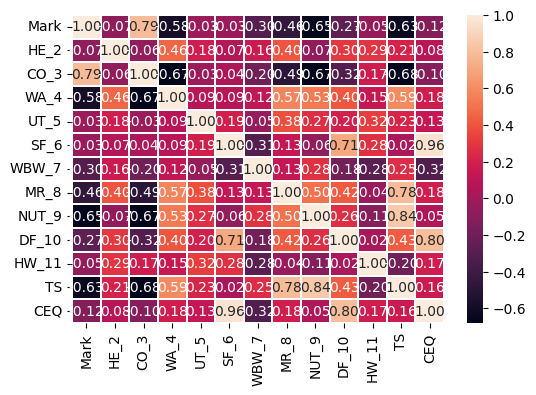

In [ ]:
# Correlation matrix FEMALE
corr = (df_fem.drop(['Mark_1'],axis=1).corr())

f,ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr, annot = True, linewidths=1.2 , fmt = '.2f',ax=ax)
plt.show()

In [ ]:
#4 "best" Features:
logit_model=sm.Logit(y_train_f,X_train_f[['CO_3','MR_8','NUT_9','TS']]) #,'SF_6','UT_5',,'CEQ','HW_11'
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.303830
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Mark             Pseudo R-squared: 0.549    
Date:               2024-08-23 06:55 AIC:              20.1532  
No. Observations:   20               BIC:              24.1361  
Df Model:           3                Log-Likelihood:   -6.0766  
Df Residuals:       16               LL-Null:          -13.460  
Converged:          1.0000           LLR p-value:      0.0020267
No. Iterations:     7.0000           Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
------------------------------------------------------------------
CO_3     5.5739     2.7170    2.0515   0.0402     0.2488   10.8991
MR_8    -4.5302     3.8910   -1.1643   0.2443   -12.1563    3.0960
NUT

In [ ]:
#5 Features:
logit_model=sm.Logit(y_train_f,X_train_f[['CO_3','MR_8','NUT_9','TS','WA_4']]) #,'SF_6','UT_5',,'CEQ','HW_11'
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.303830
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Mark             Pseudo R-squared: 0.549    
Date:               2024-08-23 06:55 AIC:              22.1532  
No. Observations:   20               BIC:              27.1319  
Df Model:           4                Log-Likelihood:   -6.0766  
Df Residuals:       15               LL-Null:          -13.460  
Converged:          1.0000           LLR p-value:      0.0052091
No. Iterations:     7.0000           Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
------------------------------------------------------------------
CO_3     5.5760     2.9110    1.9155   0.0554    -0.1294   11.2814
MR_8    -4.5387     5.7514   -0.7891   0.4300   -15.8112    6.7339
NUT

In [ ]:
#2 Features:
logit_model=sm.Logit(y_train_f,X_train_f[['NUT_9','CO_3']]) #,'SF_6','UT_5',,'CEQ','HW_11'
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.361486
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Mark             Pseudo R-squared: 0.463     
Date:               2024-08-23 06:55 AIC:              18.4595   
No. Observations:   20               BIC:              20.4509   
Df Model:           1                Log-Likelihood:   -7.2297   
Df Residuals:       18               LL-Null:          -13.460   
Converged:          1.0000           LLR p-value:      0.00041554
No. Iterations:     7.0000           Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
NUT_9     -3.4795     1.4978   -2.3230   0.0202   -6.4152   -0.5438
CO_3       3.0178     1.3438    2.2457   0.0247    0.3840 

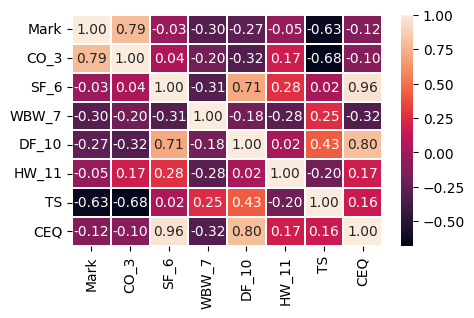

In [ ]:
# Optimize Correlation matrix FEMALE
corr = (df_fem.drop(['Mark_1','WA_4','HE_2','MR_8','NUT_9','UT_5'],axis=1).corr()) #,'UT_5','SF_6','NUT_9','CEQ','HW_11'

f,ax = plt.subplots(figsize=(5,3))
sns.heatmap(corr, annot = True, linewidths=1.2 , fmt = '.2f',ax=ax)
plt.show()

#### <u>__Building models__</u>
We must maximize _Recall_ (TRP), because human recognition is the highest priority and also not forget about _Precission_ (PPV), but if a FH is identified as a H, it is not a big loss. The F-score metric with a weight equal to the ratio of 4:1, that is, 0.8, is best suited for this.

 Also, since the sample is small and the variance associated with VAR is high, it is necessary to use a method of reducing it - a _random forest_.

### Train and test models on best futures

##### Test f score General

In [ ]:
pipe_test = Pipeline([('Feature Selection', rfe_total), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=44)
n_scores = cross_val_score(pipe_test, X_test, y_test, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.825

###### Best Fueatures General
First tier: <br>
- CO_3
- TS <br>

Second tier: <br>
- NUT_9
- WA_4


##### Test f score Male

In [ ]:
#pipe_tes = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10)
n_scores = cross_val_score(pipe_m, X_test_m, y_test_m, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.95

###### Best Fueatures Male
First tier: <br>
- CO_3
- TS <br>

Second tier: <br>
- WBW_7
- NUT_9

##### Test f score Female

In [ ]:
#pipe_tes = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10)
n_scores = cross_val_score(pipe_f, X_test_f, y_test_f, scoring='f1_micro', cv=cv, n_jobs=-1)
np.mean(n_scores)

1.0

###### Best Fueatures Female
First tier: <br>
- CO_3
- MR_8
- NUT_9
- TS

Second tier: <br>
- WA_4
- HW_11

### __Conclusions__:
 A logistic regression has been constructed for the classification of "H" and others. When segregated by gender, the results are much better, and extremely so for women. This is probably due to the larger statistics of this group.  
The best features have also been selected:
- CO_3
- TS (MR_8, NUT_9)
- WA_4
- WBW_7

__Future plans:__
- Make a multi-class classification based on probabilities. This will correspond to the spirit of research to a more significant extent, because there are no "pure" types, and each person is an amalgam in a certain proportion.
- It is planned to make the second stage of classification of pure types "F" and "M" from those mixed with the accuracy metric
- Create a telegram bot as a simple deployment solution.
- Create a second iteration of the test with the exclusion of unimportant questions and the addition of others to improve subsequent classification and confirm sociological hypotheses.

### Back-Up:

In [ ]:
#Confusion Matrix with ConfusionMatrixDisplay
X=df_male.drop(['Mark','name'],axis=1)
y=df_male['Mark']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=44,shuffle=True)
clf=LogisticRegression(random_state=44)
clf.fit(X_train, y_train)
cm=ConfusionMatrixDisplay.from_predictions(y_test,clf.predict(X_test));

 #### Non parametrical methods:
 The search for the optimal hyperparameter of the model on the grid by CV.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}

    CV_model = GridSearchCV(estimator=model,
                            param_grid=parameters,
                            cv=5,
                            scoring='f1_micro',
                            n_jobs=-1,
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']

    if draw:
        plt.figure(figsize=(8,5))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error,
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()

    return means, error

In [ ]:
from sklearn.neighbors import KNeighborsClassifier # bias
from sklearn.tree import DecisionTreeClassifier

In [ ]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(1, 11, 2), dtype='int'), np.arange(1, 30)]
param_scales = ['ordinary','ordinary']

In [ ]:
for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search_and_draw(X_train, y_train.values.ravel(), model, param_name, grid, param_scale)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [ ]:
X_train.index
y_train.dtypes

In [ ]:
max_trees = 100
categorical_indices = np.array( np.arange(4, 15))

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []

    X_train_kf = X_train.iloc[train_indices]
    y_train_kf = y_train.iloc[train_indices]

    X_val_kf = X_train.iloc[val_indices]
    y_val_kf = y_train.iloc[val_indices]

    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_

    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)

        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(fbeta_score(y_val_kf, np.round(thinned_forest.predict_proba(X_val_kf)[:, 1]),beta = 4, average='micro' ))

    scores = np.array(scores)

    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0);
None

In [ ]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values,
                 mean_cross_val_score - 2 * std_cross_val_score,
                 mean_cross_val_score + 2 * std_cross_val_score,
                 color='green',
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

##### XGBoost

In [ ]:
!pip install xgboost

In [ ]:
import xgboost

In [ ]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

#### BootStrap
Because data is small let's use bootstrap.

In [ ]:
#Bootstrap
# Set the random seed for reproducibility
np.random.seed(44)
data = t_df

# Number of bootstrap samples
num_samples = 20

# Initialize empty lists to store bootstrap samples and testing sets
bootstrap_training_sets = []
bootstrap_testing_sets = []

for _ in range(num_samples):
    # Perform bootstrap resampling
    bootstrap_sample_indices = np.random.choice(len(data), size=len(data), replace=True)
    bootstrap_sample = data.iloc[bootstrap_sample_indices, :]
    bootstrap_training_sets.append(bootstrap_sample)

    # Identify the indices of the testing set (unsampled data points)
    testing_set_indices = np.setdiff1d(np.arange(len(data)), bootstrap_sample_indices)
    testing_set = data.iloc[testing_set_indices, :]
    bootstrap_testing_sets.append(testing_set)

In [ ]:
#Bootstrap
fsc = []
for training_set,testing_set in zip(bootstrap_training_sets,bootstrap_testing_sets):
  X_train=training_set.drop(['Mark','name','Mark_1'],axis=1)
  y_train=training_set['Mark']
  X_test=testing_set.drop(['Mark','name','Mark_1'],axis=1)
  y_test=testing_set['Mark']

  clf=LogisticRegression(random_state=44)
  clf.fit(X_train, y_train)

  f_test= fbeta_score(y_test,clf.predict(X_test), average='micro', beta=2)
  f_train= fbeta_score(y_train,clf.predict(X_train),average='micro', beta=2)

  wtest=len(y_test)/(len(y_test)+len(y_train))
  wtrain=len(y_train)/(len(y_test)+len(y_train))
  fsc.append(f_test*wtest + f_train*wtrain)
#display(fsc)
np.mean(fsc)

#### Logistic Regression:

In [ ]:
X = df_male.drop(['Mark','name','CEQ'], axis = 1)
y = df_male['Mark']
df_n_m = df_male['name']
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train,  X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 44)

KeyError: "['name'] not found in axis"

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,y)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.405426
         Iterations: 35
                        Results: Logit
Model:              Logit            Method:           MLE    
Dependent Variable: Mark             Pseudo R-squared: 0.403  
Date:               2024-08-23 06:56 AIC:              44.9751
No. Observations:   53               BIC:              46.9454
Df Model:           0                Log-Likelihood:   -21.488
Df Residuals:       52               LL-Null:          -35.969
Converged:          0.0000           LLR p-value:      nan    
No. Iterations:     35.0000          Scale:            1.0000 
--------------------------------------------------------------
        Coef.   Std.Err.    z    P>|z|     [0.025     0.975]  
--------------------------------------------------------------
Mark   21.7503 11266.6932 0.0019 0.9985 -22060.5626 22104.0631



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression( )

model.fit(X_train, y_train)
model.get_metadata_routing()

{'fit': {'sample_weight': None}, 'score': {'sample_weight': None}}

 we use micro-averaging because in the case of an increase in the sample, the number of H will become much less than M and F

In [ ]:
#Holdout Method With Shuffling and Random Subsampling
num_samples = 10

fsc = []
for _ in range(num_samples):
  X_train,  X_test,y_train, y_test  = train_test_split(X, y, test_size=0.2,shuffle = True)
  clf=LogisticRegression(random_state=44)
  clf.fit(X_train, y_train)
  fsc.append(fbeta_score(y_test, clf.predict(X_test), average='micro', beta=4) )
display(fsc)
np.mean(fsc)

[0.5454545454545454,
 1.0,
 0.9090909090909091,
 1.0,
 0.8181818181818182,
 0.7272727272727273,
 0.8181818181818182,
 0.9090909090909091,
 0.8181818181818182,
 0.9090909090909091]

0.8454545454545453

In [ ]:
#Leave-One-Out
loo = LeaveOneOut()
X = df_male.drop(['Mark','name'], axis=1)
y = df_male['Mark']
fsc = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = LogisticRegression(random_state=44)
    clf.fit(X_train, y_train)
    fsc.append(fbeta_score(y_test, clf.predict(X_test), average='micro', beta=4))

np.mean(fsc)

KeyError: "['name'] not found in axis"

In [ ]:
#Bootstrap fraction not chosen
(len(bootstrap_sample_indices)-len(np.unique(bootstrap_sample_indices)))/len(bootstrap_sample_indices)

In [ ]:
#Bootstrap fraction chosen
len(np.unique(bootstrap_sample_indices))/len(bootstrap_sample_indices)

In [ ]:
#bootstrap_training_sets[1]

In [ ]:
plt.scatter(range(1,df_male.drop(['name'],axis = 1).shape[1]+1),ev)
plt.plot(range(1,df_male.drop(['name'],axis = 1).shape[1]+1),ev)
plt.title('График каменистой осыпи для определения необходимого \
          кол-ва факторов')
plt.xlabel('Факторы')
plt.ylabel('Собственные значения')
plt.axhline(y=1,c='k');

####План
1. Предобработка
- пропущенные
- ...
2. какие то распределения
сделать дерево для определения прикзнаков
3. классификация
если погрешность на фолдах большая это значит переобучение и его надо снижать
4. вывод

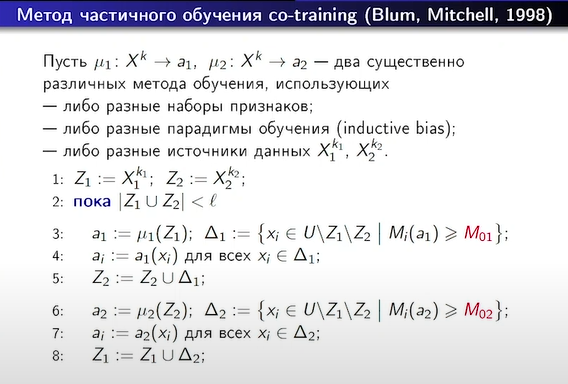

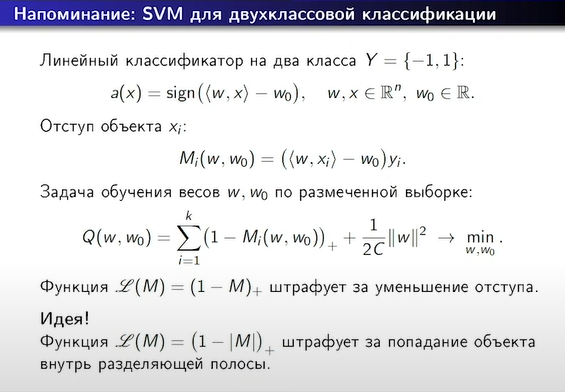

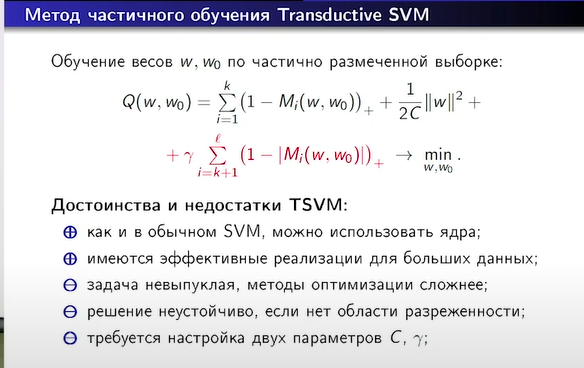

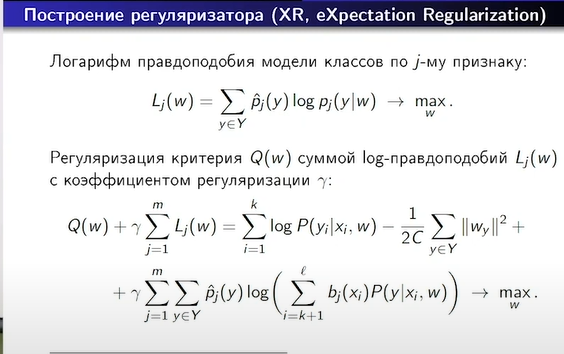